# Aufgabe 2 - Benchmarks mit dem Bridge Sampling  
In dieser Datei wird das normal_Bridge_Sampling mithilfe von verschiedenen Benchmarkumgebungen ausgewertet. Es werden hierbei die benötigten Kollisionstests für die Umgebung ausgewertet und die Rechendauer.

Am Ende wird Bridge mit Gauss verglichen.

### Einbinden aller erforderlichen Bibliotheken und Files 

In [11]:
import matplotlib.pyplot as plt 
%matplotlib inline

import networkx as nx  # Library for hanling graphs (please check 4_Introduction_Graph)
import random # possibility to create random numbers (The "P" in PRM)

import numpy as np # functions for some calculations 
import math # functions for some calculations 

from IPPerfMonitor import IPPerfMonitor

# sort nearest neighbour brute force
import heapq
import copy
# reduce coding effort by using function provided by scipy
from scipy.spatial.distance import euclidean


import importlib # usfull to relaod Files without the need to restart the kernel 
import IPTestSuite # import the enviroment for our Benchmarks 
dim=2

### "inSameConntectedCoponent" 
Die Funktion  schaut ob die übergebenen Punkte in der selben Komponente liegen

In [12]:
def inSameConnectedComponent(node1, node2, graph):
    """ Check whether to nodes are part of the same connected component using
        functionality from NetworkX
    """
    for connectedComponent in nx.connected_components(graph):
        if (node1 in connectedComponent) & (node2 in connectedComponent):
            return True
        
    return False

### "nearestNeighboursX" 
Die Funktion  findet zu einem gegebenen Punkt alle Punkte in einem gegebenen Radius und sortiert diese mit aufsteigender Distanz in einen Heap 

In [13]:

def nearestNeighboursX(pos, graph, radius):
    """ Brute Force method to find all nodes of a 
    graph near the given position **pos** with in the distance of
    **radius** in **increasing order**"""
    
    heap = list()
    for node in graph.nodes(data=True): # using (data=True) will generate a list of nodes with all attributes
        if euclidean(node[1]['pos'],pos) < radius:
            # use a heap-queue to sort the nodes in increasing order
            heapq.heappush(heap, (euclidean(node[1]['pos'] ,pos), node))
            #if len(heap) > 2 :
            #    break

    result = list()
    while len(heap) > 0 :
         result.append(heapq.heappop(heap)) 
    
    return result
            
            

### "Simple_Bridge_Sampling" 
Die Funktion  erzeugt Punkte nach dem Bridge Sampling verfahren 

In [14]:
def simple_Bridge_Sampling(collChecker):
    limits = collChecker.getEnvironmentLimits()  # get the limits from the enviroment 
    pos = [random.uniform(limit[0],limit[1]) for limit in limits] # generating a random pose within the limits 

    if not collChecker.pointInCollision(pos): # check if the pos is in collision 
        return False    # return false if pos is not in collision 
    d = np.random.normal(2,2) # get the distance d to the next point over a gaussian normal distribution 
    pos_x=pos[0]# store the x position of the pos
    pos_y=pos[1]# store the y position of the pos 
    alpha=random.uniform(0,360)*(math.pi/180) #get an random angle in rad between 0 and 180 degree 
    pos2_x=d*math.cos(alpha)+pos_x # calculate the x position for pos2
    pos2_y=d*math.sin(alpha)+pos_y # calculate the y position for pos2 
    pos2=[pos2_x,pos2_y]# store pos2 

    if not collChecker.pointInCollision(pos2):# check if pos2 is in collision 
        return False    # return false if pos is not in collision 
        
    pos3_x=(pos_x+pos2_x)/2 # calculate the x value of the intermediate point
    pos3_y=(pos_y+pos2_y)/2 # calculate the y value of the intermediate point 
    pos3=[pos3_x,pos3_y]# store pos3 

    if collChecker.pointInCollision(pos3):# check if pos3 is in collision 
        return False # return fals if pos3 is in collision 
        
    return pos3 # return pos3 wich now can be added to the roadmap  


### Die Funktion "normal_Bridge_Sampling" erzeugt Punkte nach dem Bridge Sampling verfahren
im Unterschied zum vorher gezeigten Verfahren wird der erste Punkt solange neu gewählt, bis ein Punkt gefunden wurde der Kollidiert. 
Anschließend wird zu diesem Punkt in einer Schleife ein zweiter Punkt mit einem Abstand d(Gauße Normalverteilung) und varierenden Winkel gesucht. Dadurch, dass zu dem ersten gefunden Punkt ein zweiter, nicht kollidierender Punkt in einer Schleife gesucht wird, werden hier deutlich mehr Kollision Checks benötigt und die Berechnungsdauer dauert länger. Aufgrund Dessen wurden für die Benchmark Versuche die Funktion "Simple_Bridge_Sampling" verwendet.

In [15]:
def normal_Bridge_Sampeling(collChecker):
    
    limits = collChecker.getEnvironmentLimits()  # get the limits from the enviroment       
    pos = [random.uniform(limit[0],limit[1]) for limit in limits] # generating a random pose within the limits 
    
    
    #get a colliding point
    for t in range(0,10):# if no valid configuration with the pos was found pich a new first point(10 times)
        while not collChecker.pointInCollision(pos):# generate a randmom pos until the pos is in collision 
            pos = [random.uniform(limit[0],limit[1]) for limit in limits]
        
        
        pos_x=pos[0] # store the x position of the pos
        pos_y=pos[1] # store the y position of the pos
    
        for i in range(0,50): # check the angles for pos and a distance d if no valid config was found pick an new distance d(50 times)
            
            d=np.random.normal(2,2)# get the distance d to the next point over a gaussian normal distribution 
            angle_list = [0,2*math.pi] # create a angle list with value 0 and two pi
            for n in range(4):
                
                templist = copy.deepcopy(angle_list)# make a true copy from the angle list
                new_angles_list =[]# create a new angle list
                verschoben = 1 #set the var for the shift to one 
                for idx in range(len(templist)-1):
                    new_angle = (templist[idx]+templist[idx+1])/2 # create a new angle that is between the two picked angles 
                    new_angles_list.append(new_angle)# append the new angle
                    angle_list.insert(idx+verschoben,new_angle)# insert the new angle in the angle list
                    verschoben +=1 # increase the shift 
                for alpha in new_angles_list: # calculate the pos2 for the angles in the new_angle_list  
                    pos2_x= d*math.cos(alpha)+pos_x# calculate the x position for pos2
                    pos2_y= d*math.sin(alpha)+pos_y# calculate the y position for pos2
                    pos2=[pos2_x,pos2_y]# store pso2
                    if  collChecker.pointInCollision(pos2): #check if pos2 is in collision 
                        break # if pos2 is in collison continue wiht calculation of the third point 
                pos3_x=(pos_x+pos2_x)/2 # calculate the x value of the intermediate point
                pos3_y=(pos_y+pos2_y)/2 # calculate the y value of the intermediate point 
                pos3=[pos3_x,pos3_y]  #  store the pos3 
                if collChecker.pointInCollision(pos3): # check if pos3 is in collision 
                    continue # if in collision continue 
                else:
                    return pos3 # return pos3 wich now can be added to the roadmap  
                    
    return False # if no valild configuration could be found return False

###  "learn_RoadmapNearestNeighbour" 
Die Funktion erzeugt eine vorgegebene Anzahl an Punkte mit dem Bridge Sampling Verfahren und fügte diese der Roadmap hinzu

In [16]:
def learnRoadmapNearestNeighbour(graph, dim, radius, numNodes, collisionChecker):
    i = 1
    while i < numNodes: # generate new nodes until the desired number has been reached 
      
        pos=False# initalize the pos var 
        #num_loops = 0 # set the counter for the count of the loops  to zero 
        while pos==False: # create a new point with the Bridge Sampling until a valid point is returned 
            #num_loops += 1# increase the loop counter 
            pos = simple_Bridge_Sampling(collisionChecker)
            #if num_loops > 200:# if the loop counter is over 200 stop the sampling - protect from deadlocks 
                #break
        
        # Find set of candidates to connect to sorted by distance
        #result = nearestNeighboursX(pos, graph, radius) # commented out because we dont want the result path for our Benchmarks 
        
        # check connection
        if pos is not False:
            graph.add_node(i, pos=pos)
            
        # commented out because we dont want the result path edges for our Benchmarks 
        """
        for idx, data in enumerate(result):
            if not inSameConnectedComponent(i,data[1][0],graph):
                if not collisionChecker.lineInCollision(pos,data[1][1]['pos']):
                    graph.add_edge(i,data[1][0])
        """           
        i+=1


### "find_Path" 
Die Funktion  versucht einen Pfad von der Start zur Ziepose zu finden mit der erzeugten Roadmap 


In [17]:
def findPath(graph, start, goal,collisionChecker):
    # find nearest, collision-free connection between node on graph and start
    result = nearestNeighboursX(start, graph, radius)
    for node in result:
        if not collisionChecker.lineInCollision(start,node[1][1]['pos']):
            graph.add_node("start", pos=start)
            graph.add_edge("start",node[1][0])
            break;
    # find nearest, collision-free connection between node on graph and goal
    result = nearestNeighboursX(goal, graph, radius)
    
    for node in result:
        if not collisionChecker.lineInCollision(goal,node[1][1]['pos']):
            graph.add_node("goal", pos=goal)
            graph.add_edge("goal",node[1][0])
            break;
    # find shortest path on graph
    path = nx.shortest_path(graph,"start","goal")
    # return nodelist
    return path
    

### "basicPRMVisualize" 
Die Funktion  visualisiert die Benchmark umgebungen mit deren Hindernissen und der dazu erzeugten Roadmap

In [18]:
def basicPRMVisualize(graph, collChecker, solution, nodeSize=300.0, ax=None):
    # get a list of posiations of all nodes by returning the content of the attribute 'pos'
    pos = nx.get_node_attributes(graph,'pos')
    
    # draw graph (nodes colorized by degree)
    nx.draw_networkx_nodes(graph, pos,  cmap=plt.cm.Blues, ax = ax, node_size=nodeSize)
    """
    nx.draw_networkx_edges(graph,pos,
                                ax = ax
                                )
    """
   
    
    #Auskommentiert für Aufgabenstellung 1
    collChecker.drawObstacles(ax)
    
    
    # draw nodes based on solution path
    Gsp = nx.subgraph(graph,solution)
    nx.draw_networkx_nodes(Gsp,pos,
                            node_size=300,
                             node_color='g',  ax = ax)
        
    # draw edges based on solution path
    #nx.draw_networkx_edges(Gsp,pos,alpha=0.8,edge_color='g',width=10,  ax = ax)
        
    # draw start and goal
    """"
    if "start" in graph.nodes(): 
        nx.draw_networkx_nodes(graph,pos,nodelist=["start"],
                                   node_size=300,
                                   node_color='#00dd00',  ax = ax)
    if "goal" in graph.nodes():
        nx.draw_networkx_nodes(graph,pos,nodelist=["goal"],
                                   node_size=300,
                                   node_color='#DD0000', ax = ax)
    """
    

### Importieren der Benchmark Umgebung 

In [19]:
for benchmark in IPTestSuite.benchList:
    print(benchmark.name)

Trap
Bottleneck
Fat bottleneck
Spirals
Entrance
Entrances
KIT
Inside
SSL
Ring
Hemispheres
Hammerhead
Zigzag
Spiral
medium
medium2
L-square
Teeth
Gearshift
Squares_easy
Zigzag_medium
Zigzag_hard
Japan
Haystack
HairPerson
M Sahpe(JM)
Random Field (LB)
stick figure (AA)
Double Circle(JM)
Sun Scribble (FP)
Wpoint (SS)
Points Field (NC)
Hi (TN)
S Field
HKA (SS)
HKA (HKA)
tLines (TK)
U Lines (KA)
Ricos Moderne Kunst
Pillars (MA)
Random Bubbles (MS)
Point Matrix (CH)
VFB (LD)
Face (JS)
Maze (AZ)
Robo (FP)
Stickman (MK)
House (AZ)
2030+ (2030+)
Random Bubbles (MS)


### Erzeugen der Roadmap für alle geladenen Benchmarks

Planning:  Trap
pointInCollision- Aufrufe 100107
Failed Either source start or target goal is not in G
Planning:  Bottleneck
pointInCollision- Aufrufe 20974
Failed Either source start or target goal is not in G
Planning:  Fat bottleneck
pointInCollision- Aufrufe 31206
Failed Either source start or target goal is not in G
Planning:  Spirals
pointInCollision- Aufrufe 17872
Failed No path between start and goal.
Planning:  Entrance
pointInCollision- Aufrufe 13087
Failed Either source start or target goal is not in G
Planning:  Entrances
pointInCollision- Aufrufe 3446
Failed Either source start or target goal is not in G
Planning:  KIT
pointInCollision- Aufrufe 12518
Failed Either source start or target goal is not in G
Planning:  Inside
pointInCollision- Aufrufe 25654
Failed No path between start and goal.
Planning:  SSL


c:\Users\jonas\Documents\08_Master\Python_Projekte\Roboter_Programmierung\Roboterprogrammierung_Projektarbeit\venv\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


pointInCollision- Aufrufe 35519
Failed Either source start or target goal is not in G
Planning:  Ring
pointInCollision- Aufrufe 239012
Failed Either source start or target goal is not in G


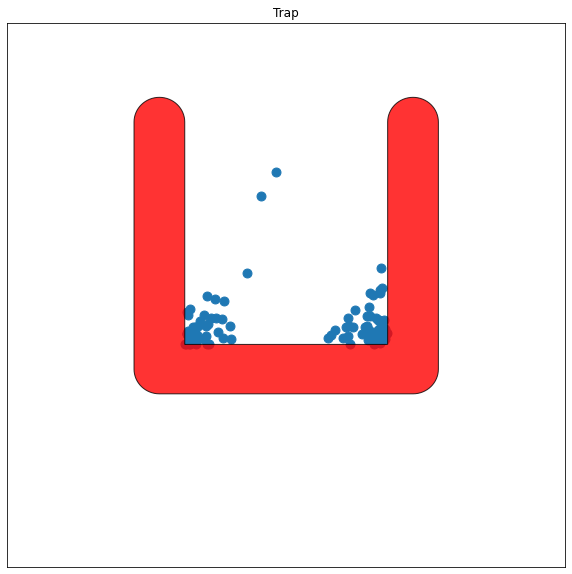

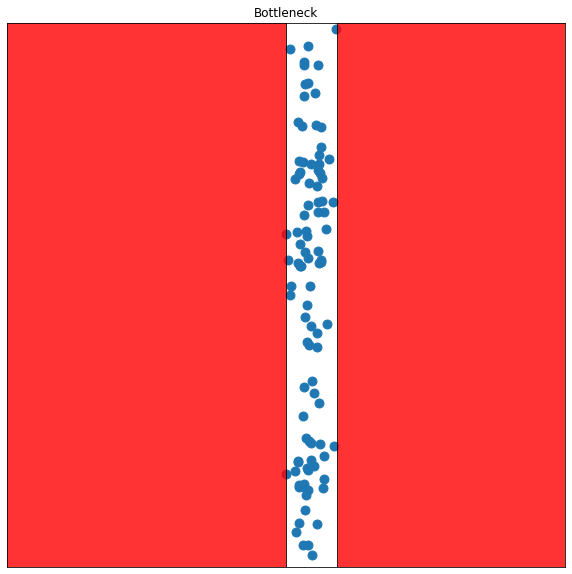

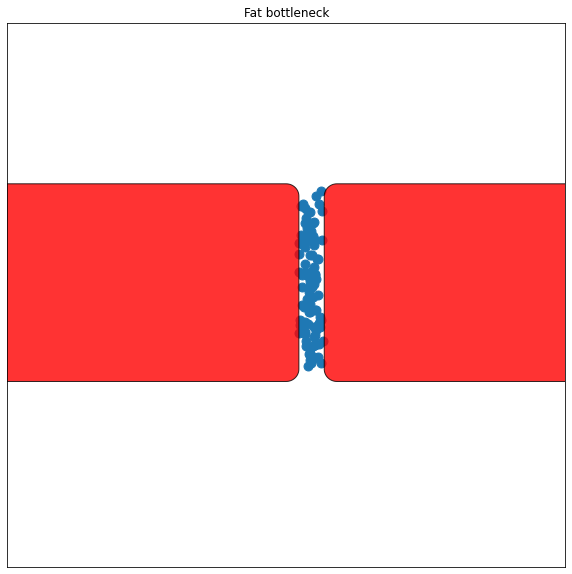

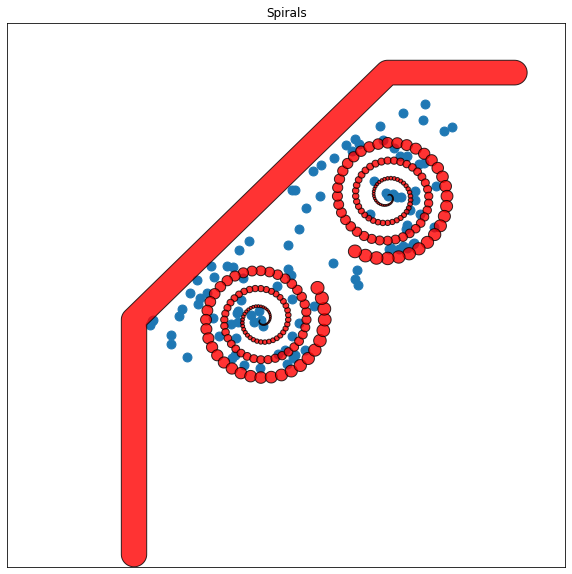

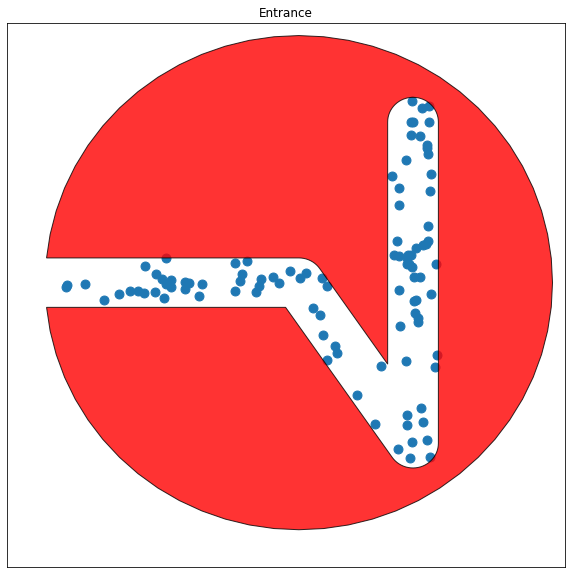

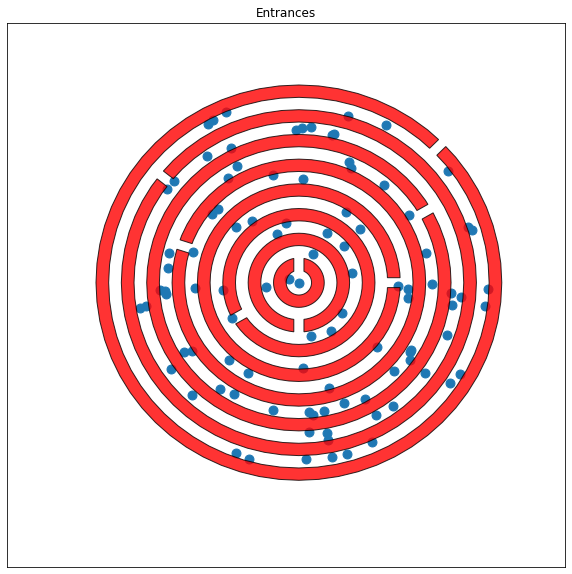

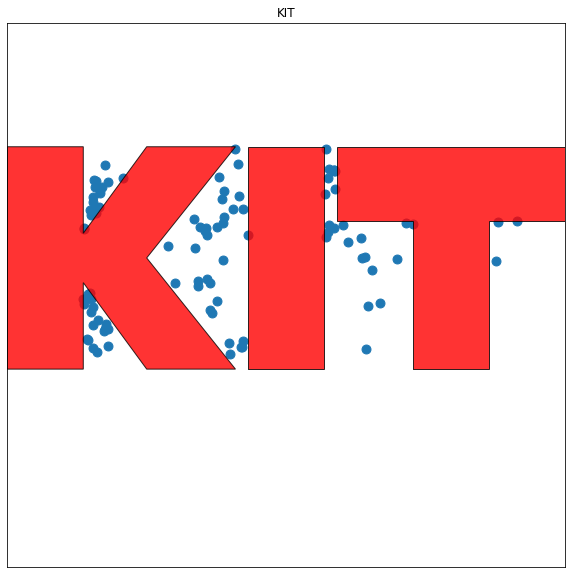

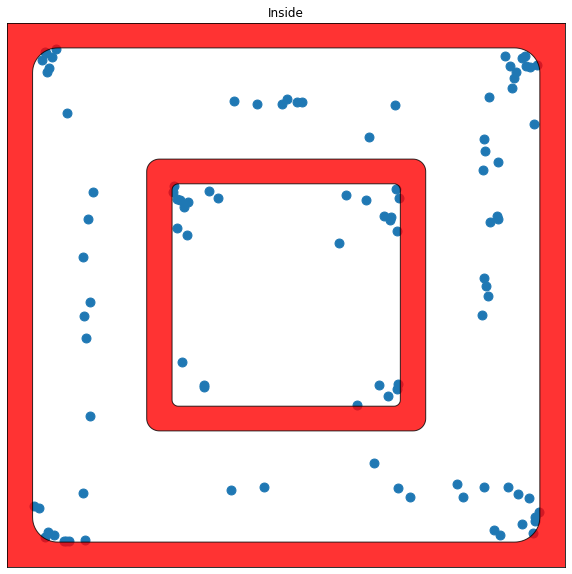

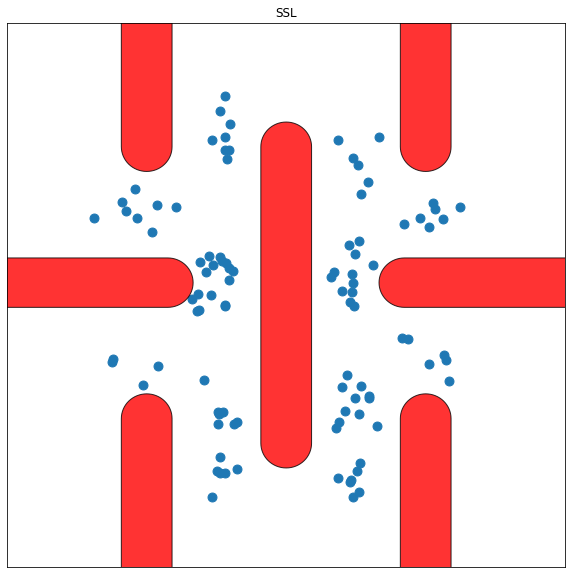

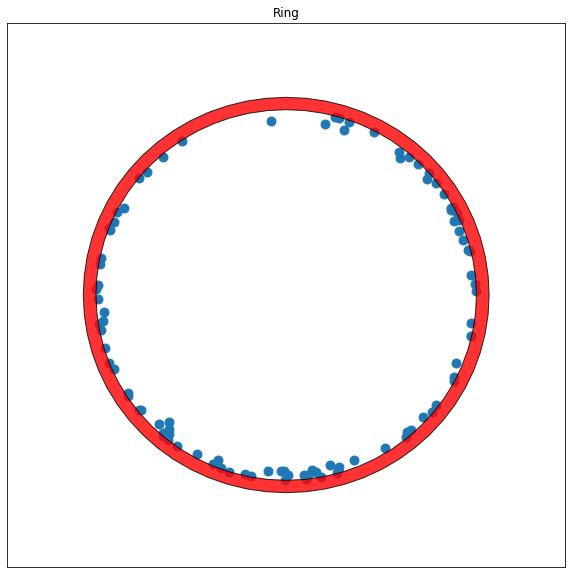

In [20]:
temp_list=IPTestSuite.benchList[:10]
coll_list = []
#iterate through all benchmark environments
for benchmark in temp_list:
    if benchmark.name == "Japan":
        continue
    try:
        benchmark.name
        print ("Planning: ", benchmark.name)
        collChecker = benchmark.collisionChecker
        G = nx.Graph()
        radius = 3.0
        numNodes = 100

        #Count Collision Checks
        IPPerfMonitor.clearData() 

        learnRoadmapNearestNeighbour(G, dim, radius, numNodes, collChecker)

        Function_infos = IPPerfMonitor.dataFrame()
        counts_for_collision = len(Function_infos[Function_infos["name"]=="pointInCollision"])
        print("pointInCollision- Aufrufe", counts_for_collision)
        #collects the collision checks from the different benchmark enviroments in a list
        coll_list.append(counts_for_collision)

        solution = findPath(G,benchmark.startList[0],benchmark.goalList[0], collChecker)
        print(solution, len(solution))
        print(len(G.nodes()))
        
    except Exception as e:
        solution = []
        print ("Failed", e)
    # draw the planning
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    limits=collChecker.getEnvironmentLimits()
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_title(benchmark.name)
    basicPRMVisualize(G,collChecker,solution,nodeSize=80,ax=ax)

### Ergebnisse der Benchmarks
**Paramter für die Benchmarks:**
* Mittelwert der Gauß Normalverteilung - 2
* Standardabweichung der Gauß Normalverteilung - 2
* Anzahl der zu erzeugenden Punkte - 100 
* Das Abbruch Krieterium um bei einem zu häfigen Aufruf der Sampling Strategie abzubrechen wurde auskomentiert

<img src="img-ip-5-0/Aufgabe_2_Projektarbeit_Bild_1.png" width=250em style="float: mid;" />
<img src="img-ip-5-0/Aufgabe_2_Projektarbeit_Bild_2.png" width=250em style="float: mid;" />
<img src="img-ip-5-0/Aufgabe_2_Projektarbeit_Bild_3.png" width=250em style="float: mid;" />

Wie auf den Bildern der Benchmarks schön zu sehen ist, werden vorallem Punkte in den Engstellen erzeugt. Problematisch könnte es bei runden Objketen werden, welche komplett ausgefüllt sind. Dort können mit dem Bridge Sampling keine Konfiguration gefunden werden, bei denen die beiden äußren Punkte kollidieren und der mittlere Punkt Frei ist.
Außerdem zu beachten ist, dass bei Unterschiedlichen Abständen der Hindernisse die Paramter der Gaußschen Normalverteilung angepasst werden müssen(Mittelwert und Standardabweichung)

**Vergleich zwischen Bridge Sampling und Gauß Sampling**

Die Anzahl von 100 Punkten wurde vorgegeben und die Anzahl der Kollisionschecks und die Dauer der Berechungn der einzelnen Punkte verglichen.

<img src="img-ip-5-0/Aufgabe_2_Projektarbeit_Bild_7.png" width=500em style="float: mid;" />

Deutlich zu erkenn ist, dass das Gaußsampling deutlich schneller als das Bridge Sampling ist und weniger Kollisionscheks benötigt. Das liegt vor allem daran, dass beim Bridge Sampling Verfahren ein Punkt mehr auf Kollision geprüft werden muss als beim Gauß Sampling. Des Weiteren ist die Wahrscheinlichkeit, dass 3 Punkte die Bedingungen(Kollision,Kollision,Kollisionsfrei) hintereinander füllen deutlich geringer als beim Gauß Sampling bei denen es nur zwei Bedingungen sind(Kollision,Kollisionsfrei). 
Dennoch lassen sich die beiden Verfahren nur bedingt vergleichen, da sie zwei unterschiedliche Ziele verfolgen. Das Gauß Sampling möchte möglichst viele Punkte um Objekte herum erzeugen. Das Bridge Sampling soll Punkte in engen Passagen erzeugen. Deshalb muss man je nach Umgebung abschätzen welches Verfahren das geeignete ist.